# <center> Neural Networks and Deep Learning Project - 2023/24

#### Student: Lorenzo Cavezza 
#### Matricola: 2130648

## Convolutional WGAN for Cosmological N-Bodies Simulations' Generation

This jupyter notebook aims to implement an efficient DCWGAN architecture for generating accurate 3D mass distribution of the Universe's Large Scale Structure according to physically meaningful metrics. Most details are inside the report.

In [1]:
# Importing the necessary libraries
import os
import time as time
from IPython import display
import pickle as pkl
import math as m
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.utils as nn_utils
import torch.nn.functional as F
import torch.distributed as dist
import torch.multiprocessing as mp
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
from scipy.ndimage import maximum_filter
from scipy.fft import fftn
from scipy.signal import correlate
from scipy.stats import wasserstein_distance
import optuna
from IPython.display import FileLink
import gc
import copy
from sklearn.metrics import roc_curve, auc


# Global Variables
ngrid = 256
bins = 100
batch_size = 16
batch_size_inner = 8
batch_size_test = 8
n_samples_train = 992
n_samples_inner = 128
n_samples_test = 128

## Dataset Building and Retrieval

The following code builds the 3D histogram from N-body simulations using predefined functions from the Indra Suite, where the dataset was stored:

In [ ]:
boxlen = 1000.
npart = 1024
cell_len = np.float64(boxlen)/np.float64(ngrid)
redshifts = [41] # Redshift 1
simulations = [i for i in range(512)]

for r in redshifts:  
    ind = 0
    for s in simulations:
        output_name = "snapshot_"
        start = time.time()
        runnum = s
        snapnum = r
        output_name += str(r) + "_"
        output_name += str(s) + ".pkl"

        # Indra custom functions
        pos = indra.getpos(runnum,snapnum)
        mesh = np.zeros((ngrid,ngrid,ngrid))
        posnorm = pos/cell_len # normalize positions
        affine = Affine(ndim=3, period=ngrid) # takes care of periodic boundary conditions
        CIC.paint(mesh,posnorm,transform=affine)
        meanden = np.mean(mesh.flatten())
        delta = mesh/meanden-1
        ind += 1
        
        with open(output_name, 'wb') as f: 
            pkl.dump(delta, f)
        end = time.time()
        print(r,s,end-start)

## Data Augmentation

Exploiting the Universe's isotropy and homogeneity I can artificially augment the number of samples in the dataset through shifts and rotations. <br>
To do so I generate one new sample from each old one by rolling the box in a random direction by a random amount of pixels and rotate it in a random direction by a random multiples of $\frac{\pi}{2}$. Thanks to this I will have doubled my initial dataset to about 1300 samples, mind this operation was done locally and the later obtained new dataset was uploaded on kaggle.

In [ ]:
# Code used locally to augment the dataset

for i in range(512):
    print(i)
    start = time.time()
    in_string = "snapshot_41_" + str(i) + ".pkl"
    with open(in_string, 'rb') as f:
        data_numpy = pkl.load(f)
        
    shift_dir = np.random.choice([0,1,2]) # random direction of the shift
    shift_magn = np.random.randint(1,511) # random number of pixels to shift
    rot_axes = np.random.choice([0, 1, 2], size=2, replace=False) # direction to rotate
    rot_magn = np.random.randint(1,5) # random multiple of 90 degrees to rotate

    # Shifting
    new_data_shifted = np.roll(data_numpy, shift = shift_magn, axis = shift_dir)

    # Rotating
    new_data = np.rot90(new_data_shifted, k = rot_magn, axes = rot_axes)
    
    out_string = "snapshot_41_" + str(i + 512) + ".pkl"
    with open(out_string, 'wb') as f:
        pkl.dump(new_data, f)
    end = time.time()
    print(end-start)

## Preprocessing

I modify the original distributions in order to make them less skewed towards 0 and to define them between 0 and 1, this will greatly improve training.

In [3]:
# Defining preprocessing tranformations

# Forward Tranformation
def log_lin_transf_prime (x, cut):
    return np.where(x <= cut, 3 * np.log(x + 1), 3 * (np.log(cut + 1) + (x / cut) - 1))
    
def log_lin_transf (x, cut, stride, x_min):
    x = x - x_min
    output = log_lin_transf_prime (x + stride, cut) - log_lin_transf_prime (stride, cut)
    output_max = output.max()
    #print(output_max)
    final_output = output/output_max
    return (final_output, output_max)

# Inverse Tranformation
def back_log_lin_transf_prime (y, cut):
    return np.where(y <= 3 * (np.log(cut + 1)), np.exp(y / 3) - 1, cut * ((y / 3) + 1 - np.log(cut + 1)))
    
def back_log_lin_transf (y, cut, stride, output_max):
    return (back_log_lin_transf_prime (y*output_max + log_lin_transf_prime (stride, cut), cut) - stride)

# Defining transformation parameters
c = 11
s = 0.002

## Metrics Used

Here I define the metrics used for the summary loss and the evaluation process in general. I define both a numpy built version for CPU computing and a torch built one for GPU computing.

In [4]:
def peak_histogram(inpu, neighbors, bins):
# Computing the Peak Histogram on the CPU
    
    
    local_max = maximum_filter(inpu, size=neighbors * 2 + 1, mode='constant', cval=0)
    peaks = inpu[inpu == local_max]
    data_min, data_max = np.min(peaks), np.max(peaks)
    peaks_hist, peaks_edges = np.histogram(np.array(peaks), bins=bins, range=(data_min, data_max), density=True)
    bin_centers = (peaks_edges[:-1] + peaks_edges[1:]) / 2
    return bin_centers, peaks_hist

def peak_histogram_torch(input_tensor, neighbors, bins, range=(0, 1)):
# Computing the Peak Histogram on the GPU

    pooled = torch.nn.functional.max_pool3d(
        input_tensor.unsqueeze(0).unsqueeze(0),
        kernel_size=2 * neighbors + 1,
        stride=1,
        padding=neighbors
    ).squeeze(0).squeeze(0)

    peaks_mask = (input_tensor == pooled)
    peak_values = input_tensor[peaks_mask]
    bin_centers, hist = mass_histogram_torch(peak_values.flatten(), bins, range)
    
    return bin_centers, hist

def mass_histogram (inpu, bins):
# Computing the Mass Histogram on the CPU

    mass_hist, mass_edges = np.histogram(inpu, bins = bins, density = True)
    
    return (mass_edges[:-1], mass_hist)
    
def mass_histogram_torch(tensor, bins, range=(0, 1)):
# Computing the Mass Histogram on the GPU

    bin_edges = torch.linspace(range[0], range[1], steps=bins + 1, device=tensor.device)
    hist = torch.histc(tensor, bins=bins, min=range[0], max=range[1])
    bin_width = (range[1] - range[0]) / bins
    hist = hist / (hist.sum() * bin_width + 1e-8)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    return bin_centers, hist
    
def power_spectrum(field_x, bin_k, size=32, log_sampling=True):
# Computing the Power Spectrum on the CPU
    
    freq = np.fft.fftfreq(n=size, d=1) * 2 * np.pi 
    kx, ky, kz = np.meshgrid(freq, freq, freq, indexing='ij')
    k_abs = np.sqrt(kx**2 + ky**2 + kz**2)
    
    fft_field = np.fft.fftn(field_x)
    power_spec = np.abs(fft_field)**2

    k_nonzero = k_abs[k_abs > 0]
    if k_nonzero.size == 0:
        return np.zeros(bin_k), np.zeros(bin_k)
    k_min = k_nonzero.min()
    k_max = k_abs.max()
    
    if log_sampling:
        bin_edges = np.logspace(np.log10(k_min), np.log10(k_max), bin_k + 1)
    else:
        bin_edges = np.linspace(k_min, k_max, bin_k + 1)
    
    k_flat = k_abs.ravel()
    power_flat = power_spec.ravel()
    
    bin_indices = np.digitize(k_flat, bins=bin_edges) - 1  # now in 0..bin_k-1
    valid_mask = (bin_indices >= 0) & (bin_indices < bin_k)
    bin_indices = bin_indices[valid_mask]
    power_flat = power_flat[valid_mask]
    
    power_k = np.zeros(bin_k, dtype=np.float32)
    counts = np.zeros(bin_k, dtype=np.int32)
    np.add.at(power_k, bin_indices, power_flat)
    np.add.at(counts, bin_indices, 1)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        avg_power = np.where(counts > 0, power_k / counts, np.nan)
    
    k_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    missing = np.isnan(avg_power) | (avg_power == 0)
    valid = ~missing
    avg_power_interp = np.copy(avg_power)
    
    if np.any(valid):
        avg_power_interp[missing] = np.interp(k_centers[missing], k_centers[valid], avg_power[valid])
    
    return k_centers, avg_power_interp

def power_spectrum_torch(input_tensor, bins, size=32, log_sampling=True):
# Computing the Power Spectrum on the GPU

    fft = torch.fft.fftn(input_tensor, dim=(0, 1, 2))
    power = fft.abs().pow(2)
    device = power.device

    freq = (torch.fft.fftfreq(size, d=1) * 2 * torch.pi).to(device) 
    kx, ky, kz = torch.meshgrid(freq, freq, freq, indexing='ij')
    k_mag = torch.sqrt(kx**2 + ky**2 + kz**2)
    
    k_nonzero = k_mag[k_mag > 0]
    if k_nonzero.numel() == 0:
        return torch.zeros(bins, device=input_tensor.device), torch.zeros(bins, device=input_tensor.device)
    k_min = k_nonzero.min()
    k_max = k_mag.max()
    
    if log_sampling:
        bin_edges = 10 ** torch.linspace(torch.log10(k_min), torch.log10(k_max), bins + 1, device=input_tensor.device)
    else:
        bin_edges = torch.linspace(k_min, k_max, bins + 1, device=input_tensor.device)
    
    k_flat = k_mag.reshape(-1)
    power_flat = power.reshape(-1)
    

    bin_indices = torch.bucketize(k_flat, bin_edges, right=True) - 1
    valid_mask = (bin_indices >= 0) & (bin_indices < bins)
    bin_indices = bin_indices[valid_mask]
    power_flat = power_flat[valid_mask]
    
    sum_power = torch.zeros(bins, device=input_tensor.device, dtype=power_flat.dtype)
    sum_power.scatter_add_(0, bin_indices, power_flat)
    
    counts = torch.zeros(bins, device=input_tensor.device, dtype=torch.float32)
    counts.scatter_add_(0, bin_indices, torch.ones_like(bin_indices, dtype=torch.float32))
    
    avg_power = sum_power / counts.clamp(min=1.0)
    avg_power = torch.where(counts > 0, avg_power, torch.tensor(float('nan'), device=input_tensor.device))
    
    k_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    missing = torch.isnan(avg_power) | (avg_power == 0)
    valid = ~missing
    avg_power_interp = avg_power.clone()
    if valid.sum() > 0:
        avg_power_interp[missing] = torch_interp(k_centers[missing], k_centers[valid], avg_power[valid])
    
    return k_centers, avg_power_interp
 
def F2(k1_vec, k2_vec):
# Computing the F2 Kernel on CPU
    
    k1_mod = np.sqrt(np.dot(k1_vec, k1_vec))
    k2_mod = np.sqrt(np.dot(k2_vec, k2_vec))
    ctheta = np.dot(k1_vec, k2_vec)/(k1_mod*k2_mod)
    return 5.0/7.0 + 0.5 * ctheta * (k1_mod/k2_mod + k2_mod/k1_mod) + 2.0/7.0 * ctheta**2

def F2_torch(k1_vec, k2_vec):
# Computing the F2 Kernel on GPU

    k1_mod = torch.sqrt(torch.dot(k1_vec,k1_vec))
    k2_mod = torch.sqrt(torch.dot(k2_vec,k2_vec))
    ctheta = torch.dot(k1_vec, k2_vec) / (k1_mod * k2_mod)
    return 5.0/7.0 + 0.5 * ctheta * (k1_mod/k2_mod + k2_mod/k1_mod) + 2.0/7.0 * ctheta**2

def torch_interp(x, xp, fp):
# torch equivalent of np.interp 

    device = xp.device
    indices = torch.searchsorted(xp, x, right=True).to(device)
    indices = indices.clamp(1, len(xp) - 1)

    # Get the neighboring xp and fp values
    x0 = xp[indices - 1]
    x1 = xp[indices]
    y0 = fp[indices - 1]
    y1 = fp[indices]
    
    # Compute the fractional distance of x between x0 and x1
    weight = (x - x0) / (x1 - x0)
    interp_val = y0 + weight * (y1 - y0)
    
    # For x values below xp[0] and above xp[-1], use fp[0] and fp[-1] respectively
    interp_val = torch.where(x < xp[0], fp[0].expand_as(interp_val), interp_val)
    interp_val = torch.where(x > xp[-1], fp[-1].expand_as(interp_val), interp_val)
    
    return interp_val
    
def bispectrum(k,Pk,k1,k2,bins):
# Computing the Bispectrum on CPU

    B = np.zeros(bins, dtype=np.float64)

    thetas = np.linspace(0, np.pi, bins)
    k1_vec = np.array([0, 0, k1])

    Pk1 = np.interp(k1, k, Pk)
    Pk2 = np.interp(k2, k, Pk)

    for i,theta in enumerate(thetas):
        k2_vec = np.array([0,  k2*np.sin(theta), k2*np.cos(theta)])
        k3_vec = np.array([0, -k2*np.sin(theta),-k2*np.cos(theta)-k1])
        k3 = np.sqrt(np.dot(k3_vec, k3_vec))
        Pk3 = np.interp(k3, k, Pk)

        F2_12 = F2(k1_vec, k2_vec)
        F2_13 = F2(k1_vec, k3_vec)
        F2_23 = F2(k2_vec, k3_vec)

        B[i] = 2.0*Pk1*Pk2*F2_12 + 2.0*Pk1*Pk3*F2_13 + 2.0*Pk2*Pk3*F2_23

    return thetas,B

def bispectrum_torch(k, Pk, k1, k2, bins):
# Computing the Bispectrum on GPU

    device = k.device
    thetas = torch.linspace(0, m.pi, bins).to(device)
    B = torch.zeros(bins, dtype=torch.float32).to(device)
    k1_vec = torch.tensor([0.0, 0.0, k1], dtype=torch.float32).to(device)
    
    # For k1 and k2 we use a simple linear interpolation.
    k1t = torch.tensor(k1).to(device)
    k2t = torch.tensor(k2).to(device)
    
    Pk1 = torch_interp(k1t, k, Pk)
    Pk2 = torch_interp(k2t, k, Pk)

    for i, theta in enumerate(thetas):
        k2_vec = torch.tensor([0.0, k2t*torch.sin(theta), k2t*torch.cos(theta)], dtype=torch.float32).to(device)
        k3_vec = torch.tensor([0.0, -k2t*torch.sin(theta), -k2t*torch.cos(theta) - k1t], dtype=torch.float32).to(device)
        k3 = torch.sqrt(torch.dot(k3_vec, k3_vec))
        Pk3 = torch_interp(k3, k, Pk)
        F2_12 = F2_torch(k1_vec, k2_vec)
        F2_13 = F2_torch(k1_vec, k3_vec)
        F2_23 = F2_torch(k2_vec, k3_vec)
        
        B[i] = 2.0*Pk1*Pk2*F2_12 + 2.0*Pk1*Pk3*F2_13 + 2.0*Pk2*Pk3*F2_23
    return thetas, B

### Data Loading

Here I define a Loader class to efficiently load samples from the dataset during training.

In [5]:
class Loader(Dataset):
    def __init__(self, main_files, metrics_files):
        self.main_files = main_files
        self.metrics_files = metrics_files

    def __len__(self):
        return len(self.main_files)

    def __getitem__(self, i):

        file = self.main_files[i]
        with open(file, 'rb') as f:
            data_numpy = pkl.load(f)
        
        pre_pross_data, output_max = log_lin_transf(data_numpy, c, s, np.min(data_numpy))
        data = torch.from_numpy(pre_pross_data).float()
        data_max = torch.tensor([output_max], dtype=torch.float32)

        with open(self.metrics_files[i], 'rb') as f:
            metrics_numpy = pkl.load(f)
        metrics_tensor = torch.from_numpy(metrics_numpy).float()
        
        return data_max, data, metrics_tensor

# Training Dataset

dir = "/kaggle/input/cosmo-32-real"
dir_metrics = "/kaggle/input/data32-real-metrics"
files = [os.path.join(dir, f) for f in os.listdir(dir) if f.endswith(".pkl") and f != 'epsilons.pkl']
files_metr = [os.path.join(dir_metrics, f) for f in os.listdir(dir_metrics) if f.endswith(".pkl") and f != 'epsilons.pkl']
dataset_train = Loader(files[0:n_samples_train],files_metr[0:n_samples_train])
batch_size = 16
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
data_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

# Testing Datasets
dir_test = "/kaggle/input/data32-real-test"
dir_test_metrics = "/kaggle/input/data32-real-test-metrics"
files = [os.path.join(dir_test, f) for f in os.listdir(dir_test) if f.endswith(".pkl") and f != 'epsilons.pkl']
files_metr = [os.path.join(dir_test_metrics, f) for f in os.listdir(dir_test_metrics) if f.endswith(".pkl") and f != 'epsilons.pkl']

# DG dataset
dataset_inner = Loader(files[0:n_samples_inner],files_metr[0:n_samples_inner])
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
data_loader_inn = DataLoader(dataset_inner, batch_size=batch_size_inner, shuffle=True, num_workers=os.cpu_count())

# Test Dataset
dataset_test = Loader(files[n_samples_inner:n_samples_test+n_samples_inner],files_metr[n_samples_inner:n_samples_test+n_samples_inner])
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
data_loader_test = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=True, num_workers=os.cpu_count())

cuda
cuda
cuda


### Models

The models' weight initialization, a rather GAN standard weights initialization was used.

In [6]:
def weights_init(m):
    if hasattr(m, 'weight') and m.weight is not None: 
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            if classname.find('Conv3d') != -1:
                nn.init.xavier_normal_(m.weight.data)
            else:
                nn.init.kaiming_normal_(m.weight.data, a=0.2, mode='fan_in', nonlinearity='leaky_relu')
        elif classname.find('Linear') != -1:
            nn.init.xavier_uniform_(m.weight.data)
        elif classname.find('BatchNorm') != -1:
            nn.init.constant_(m.bias.data, 0)
            nn.init.normal_(m.weight.data, 1.0,0.02)

    if hasattr(m, 'bias') and m.bias is not None:
        nn.init.constant_(m.bias.data, 0)


The Generator:

In [7]:
class ResidualBlock3D(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(channels),
            nn.LeakyReLU(0.2),
            
            nn.Conv3d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(channels),
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x):
        return x + self.block(x) 

class Generator_1(nn.Module):

    def __init__(self, input_size, d):

        super(Generator_1, self).__init__()
        self.input_size = input_size
        self.d = d

        self.fc_net = nn.Sequential(
            nn.Linear(input_size, input_size * d, bias=False),
            nn.BatchNorm1d(input_size * d),
            nn.LeakyReLU(0.2)
        )

        self.conv_model = nn.Sequential(
            
            nn.ConvTranspose3d(4*d, 2*d, kernel_size=4, stride = 2,padding=1, bias=False),
            nn.BatchNorm3d(2*d),
            nn.LeakyReLU(0.2),
            
            ResidualBlock3D(2*d),
            
            nn.ConvTranspose3d(2*d, d, kernel_size=4, stride = 2,padding=1, bias=False),
            nn.BatchNorm3d(d),
            nn.LeakyReLU(0.2),
            
            ResidualBlock3D(d),
            
            nn.ConvTranspose3d(d, d//2, kernel_size=4, stride = 2,padding=1, bias=False),
            nn.BatchNorm3d(d//2),
            nn.ReLU(0.2), 
            
            ResidualBlock3D(d//2),
            
            nn.Conv3d(d//2, d//4, kernel_size=3, stride = 1,padding=1, bias=False),
            nn.BatchNorm3d(d//4),
            nn.ReLU(0.2),
            nn.Conv3d(d//4, 1, kernel_size=3, stride = 1,padding=1, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        y = self.fc_net(x)
        batch_size = x.size(0)
        y = y.reshape((batch_size, 4*self.d, 4, 4, 4))
        y = self.conv_model(y)
        return y

The discriminator:

In [8]:
class Discriminator_1(nn.Module):

    def __init__(self, d):

        super().__init__()
        self.d = d

        self.convo = nn.Sequential(
            nn_utils.spectral_norm(nn.Conv3d(1, d, kernel_size = 4, stride = 2,padding = 1, bias=False)),
            nn.LeakyReLU(0.2),
            
            nn_utils.spectral_norm(nn.Conv3d(d, 2*d, kernel_size = 4, stride = 2,padding = 1, bias=False)),
            nn.LeakyReLU(0.2),
            
            nn_utils.spectral_norm(nn.Conv3d(2*d, 4*d, kernel_size = 4, stride = 2,padding = 1, bias=False)),
            nn.LeakyReLU(0.2),
            
            nn_utils.spectral_norm(nn.Conv3d(4*d, 8*d, kernel_size = 3, stride = 1,padding = 2,dilation=2, bias=False)),
            nn.LeakyReLU(0.2),
            
            nn_utils.spectral_norm(nn.Conv3d(8*d, 8*d, kernel_size = 3, stride = 1,padding = 1, bias=False)),
            nn.LeakyReLU(0.2),

        )

        self.lin = nn.Sequential(
            nn.Linear(512*d,1),
        )


    def forward(self, x):
        y = self.convo(x)
        batch_size = x.size(0)
        y = y.reshape((batch_size,-1))
        y = self.lin(y)
        return y

### Loss

Below is the code for all the losses terms.

In [9]:
def penalty_func(discriminator, real_samples, fake_samples, device, lambd):
# Computing the gradient penaly loss term
    batch_size = real_samples.size(0)
    eps = torch.rand(batch_size,1, 1, 1, 1, device=device)
    x_lines = eps * real_samples + (1 - eps) * fake_samples
    x_lines = x_lines.requires_grad_(True) 
    
    x_lines_pred = discriminator(x_lines)
    
    grad = torch.autograd.grad(
        outputs = x_lines_pred,
        inputs = x_lines,
        grad_outputs = torch.ones_like(x_lines_pred),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
        
    grad_flat = grad.view(batch_size, -1) 
    grad_norm = grad_flat.norm(2, dim=1)
    
    penalty = ((grad_norm - 1) ** 2).mean()
    return (lambd * penalty)

In [10]:
def simpson_integration(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
# Function to integrate a distribution with Simpson method
    
    n = x.numel()
    if n < 2:
        return torch.tensor(0., dtype=x.dtype, device=x.device)

    n_intervals = n - 1
    if n_intervals % 2 == 1:
        n_triplets = n_intervals // 2  # integer division
        
        x0 = x[:2 * n_triplets:2]
        x1 = x[1:2 * n_triplets:2]
        x2 = x[2:2 * n_triplets + 1:2]
        y0 = y[:2 * n_triplets:2]
        y1 = y[1:2 * n_triplets:2]
        y2 = y[2:2 * n_triplets + 1:2]
        
        h1 = x1 - x0
        h2 = x2 - x1
        
        simpson_segments = (h1 + h2) / 6 * ( y0 * (2 - h2/h1) +
                                               y1 * ((h1+h2)**2/(h1*h2)) +
                                               y2 * (2 - h1/h2) )
        I_simpson = simpson_segments.sum()
        
        I_trap = (x[-1] - x[-2]) * (y[-1] + y[-2]) / 2
        
        I = I_simpson + I_trap
    else:
        n_triplets = (n - 1) // 2
        x0 = x[:2 * n_triplets:2]
        x1 = x[1:2 * n_triplets:2]
        x2 = x[2:2 * n_triplets + 1:2]
        y0 = y[:2 * n_triplets:2]
        y1 = y[1:2 * n_triplets:2]
        y2 = y[2:2 * n_triplets + 1:2]
        
        h1 = x1 - x0
        h2 = x2 - x1
        
        I = ((h1 + h2) / 6 * ( y0 * (2 - h2/h1) +
                                y1 * ((h1+h2)**2/(h1*h2)) +
                                y2 * (2 - h1/h2) )).sum()
    return I

def wasserstein_distance_torch_error(u_values, u_weights, v_weights, e_weights):
    # Function to compute the wasserstein distance with variance on GPU using Simpson integration and CDFs

    u_weights = u_weights / u_weights.sum()
    v_weights = v_weights / v_weights.sum()
        
    # Compute the cumulative distribution functions (CDFs)
    u_cdf = torch.cumsum(u_weights, dim=0)
    v_cdf = torch.cumsum(v_weights, dim=0)

    # Compute the Wasserstein distance (L1 norm of the CDF differences)
    simpson_integration(u_values, torch.mul(torch.abs(u_cdf - v_cdf),e_weights))
    distance = simpson_integration(u_values, torch.mul(torch.abs(u_cdf - v_cdf),e_weights))
    
    return distance

def compute_metrics (input_tensor, bins, k1l, k2l, k1h, k2h):
    # Computing the summary metrics on CPU

    # Power Spectrum
    bin_spec, power_spectrums = power_spectrum(input_tensor, bins)
        
    # Mass Histogram
    bin_mass, mass_hist = mass_histogram(input_tensor, bins)
       
    # Peak Histogram
    bin_peak, peak_hist = peak_histogram(input_tensor,2,bins)
     
    # Bispectrum low scales
    bin_bil, bil_hist = bispectrum(bin_spec, power_spectrums, k1l, k2l, bins)
    
    # Bispectrum high scales
    bin_bih, bih_hist = bispectrum(bin_spec, power_spectrums, k1h, k2h, bins)
        
    return (bin_spec, power_spectrums, bin_mass, mass_hist, bin_peak, peak_hist, bin_bil, bil_hist, bin_bih, bih_hist)

def compute_metrics_torch (input_tensor, bins):
    # Computing the summary metrics on GPU

    # Power Spectrum
    bin_spec, power_spectrums = power_spectrum_torch(input_tensor, bins)
    
    # Mass Histogram
    bin_mass, mass_hist = mass_histogram_torch(input_tensor, bins)

    # Peak Histogram
    bin_peak, peak_hist = peak_histogram_torch(input_tensor,2,bins)
    
    return (bin_spec, power_spectrums, bin_mass, mass_hist, bin_peak, peak_hist)

def summary_loss_torch(real_data, fake_data, eps, power_lambda, mass_lambda, peak_lambda):
    # Function that computes the summary loss from real and fake samples accounting for the variance on GPU

    device = fake_data.device
    unfake = fake_data.squeeze()
    real_metrics_t = real_data.permute(2,1,0,3).to(device)
    real_bins = real_metrics_t[0]
    real_metrics = real_metrics_t[1]

    power_fakes = []
    peak_fakes = []
    mass_fakes = []

    
    for fake in unfake:

        # Compute statistics for fake data
        f_bin_spec, fake_power_spectrum, f_bin_mass, fake_mass_hist, f_bin_peak, fake_peak_hist = compute_metrics_torch (fake, bins)

        power_fakes.append(fake_power_spectrum)
        mass_fakes.append(fake_mass_hist)
        peak_fakes.append(fake_peak_hist)

        
    # Converting lists to tensors
    power_fake = torch.stack(power_fakes)
    peak_fake = torch.stack(peak_fakes)
    mass_fake = torch.stack(mass_fakes)

    fake_metrics = torch.stack([power_fake, mass_fake,  peak_fake])

    fake_std, fake_mean = torch.std_mean(fake_metrics, dim=1)
    real_std, real_mean = torch.std_mean(real_metrics, dim=1)

    
    delta_f_ = torch.min(fake_mean[fake_mean>0])
    delta_r_ = torch.min(real_mean[real_mean>0])
    if (delta_f_/100 > 0) and (delta_r_/100 > 0):
        delta_f = delta_f_/100
        delta_r = delta_r_/100
    elif (delta_f_/10 > 0) and (delta_r_/10 > 0):
        delta_f = delta_f_/10
        delta_r = delta_r_/10
    else:
        delta_f = delta_f_
        delta_r = delta_r_

    #delta, epsilon = 1e-10, 1e-10 # values to avoid division by 0

    rel_fake_std = fake_std / (fake_mean + delta_f)
    rel_real_std = real_std / (real_mean + delta_r)


    rel_sum = rel_fake_std + rel_real_std
    epsilon_ = torch.min(rel_sum[rel_sum>0])
    if (epsilon_/100 > 0):
        epsilon = epsilon_/100
    elif (epsilon_/10 > 0):
        epsilon = epsilon_/10
    else:
        epsilon = epsilon_
        
    error_corr = 1.0 / (rel_sum + epsilon)

    losses = []
    for i in range(3):
        losses.append(wasserstein_distance_torch_error(real_bins.permute(1, 0, 2)[0][i], real_mean[i], fake_mean[i], error_corr[i]))
    
    # Computing final summary loss
    summaries = torch.log10(torch.stack(losses) + eps)
    lambdas = torch.tensor([power_lambda,mass_lambda,peak_lambda]).to(device)
    summary = torch.abs(torch.sum(torch.mul(summaries, lambdas)))

    return (summary)

In [11]:
def discriminator_loss(discriminator, real_output, fake_output, device, lambd, gp):
# Computing the discriminator loss, with or without GP
    
    real_output = real_output.to(device)
    fake_output = fake_output.to(device)
    real_pred = discriminator(real_output)
    fake_pred = discriminator(fake_output)
    orig_loss = fake_pred.mean() - real_pred.mean()
    if gp == True:
        penalty = penalty_func(discriminator, real_output, fake_output, device, lambd)
        return (orig_loss + penalty)
    else:
        return orig_loss

In [12]:
def generator_loss(discriminator, real_output, fake_output, eps, power_lamda, mass_lambda, peak_lambda, summ_lambda):
# Computing the generator loss
    
    disc_loss = -discriminator(fake_output).mean()
    #summ = summary_loss_torch(real_output, fake_output, eps, power_lamda, mass_lambda, peak_lambda)
    return (disc_loss)# + summ_lambda * summ)    

### Training

Here I define functions useful during the training.

In [13]:
def generate_and_save_images(model, epoch, test_input):
# Function to plot and save fake samples at each epoch
    
    model.eval()
    with torch.no_grad():
        predictions = model(test_input).detach().cpu()* 250

    grid = make_grid(predictions[:, :, :, :, 0], 5).numpy().squeeze().transpose(1, 2, 0)

    plt.imshow(grid.astype(np.uint8))
    plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

    model.train()


def plot_summary(dataloader,model, epoch, test_input):
# Function to plot the summaries at each epoch
    
    model.eval()
    with torch.no_grad():
        predictions = model(test_input).detach()

    power_reals = []
    peak_reals= []
    mass_reals = []
    bi_low_reals = []
    bi_high_reals = []
    max_list=[]

    for max_batch, image_batch, metrics_batch in dataloader:
        for (m, image) in zip(max_batch, image_batch):
            
            max_list.append(m)
            inverse_image = back_log_lin_transf (image, c, s, m)
            r_bin_spec, real_power_spectrum, r_bin_mass, real_mass_hist, r_bin_peak, real_peak_hist,\
            r_bin_bil, real_bil_hist, r_bin_bih, real_bih_hist  = compute_metrics (inverse_image, bins, k1l, k2l, k1h, k2h)
            
            power_reals.append(real_power_spectrum)
            mass_reals.append(real_mass_hist)
            peak_reals.append(real_peak_hist)
            bi_low_reals.append(real_bil_hist)
            bi_high_reals.append(real_bih_hist)
            
    maxes = np.mean(np.array(max_list))

    real_metrics = np.stack([np.stack(power_reals), np.stack(mass_reals), np.stack(peak_reals), 
                                np.stack(bi_low_reals), np.stack(bi_high_reals)])
    
    real_mean = np.mean(real_metrics, axis=1)
    real_std = np.std(real_metrics, axis=1)    
    r_bins = np.stack([r_bin_spec, r_bin_mass, r_bin_peak, r_bin_bil, r_bin_bih])
    
    power_fakes = []
    peak_fakes = []
    mass_fakes = []
    bi_low_fakes = []
    bi_high_fakes = []

    for pred in predictions:
        
        inverse_pred = back_log_lin_transf (pred.cpu().numpy(), c, s, maxes)
        f_bin_spec, fake_power_spectrum, f_bin_mass, fake_mass_hist, f_bin_peak, fake_peak_hist,\
        f_bin_bil, fake_bil_hist, f_bin_bih, fake_bih_hist  = compute_metrics (inverse_pred, bins, k1l, k2l, k1h, k2h)

        power_fakes.append(fake_power_spectrum)
        mass_fakes.append(fake_mass_hist)
        peak_fakes.append(fake_peak_hist)
        bi_low_fakes.append(fake_bil_hist)
        bi_high_fakes.append(fake_bih_hist)
 

    fake_metrics = np.stack([np.stack(power_fakes), np.stack(mass_fakes), np.stack(peak_fakes), 
                             np.stack(bi_low_fakes), np.stack(bi_high_fakes)])
    
    fake_mean = np.mean(fake_metrics, axis=1)
    fake_std = np.std(fake_metrics, axis=1)

    fig, ax = plt.subplots(2, 3, figsize=(20, 12), gridspec_kw={'height_ratios': [1, 1]})
    order = [0, 4, 3, 1, 2]
    d = 0
    for j in range(3):
        ax[0,j].plot(r_bins[order[d]],fake_mean[order[d]],label='fake', color = 'red')
        ax[0,j].fill_between(r_bins[order[d]], fake_mean[order[d]] - fake_std[order[d]], fake_mean[order[d]] + fake_std[order[d]], color='red', alpha=0.2)
        ax[0,j].plot(r_bins[order[d]],real_mean[order[d]],label='real', color = 'blue')
        ax[0,j].fill_between(r_bins[order[d]], real_mean[order[d]] - real_std[order[d]], real_mean[order[d]] + real_std[order[d]], color='blue', alpha=0.2)
        d+=1

    ax[1,0].plot(r_bins[order[d]],fake_mean[order[d]],label='fake', color = 'red')
    ax[1,0].fill_between(r_bins[order[d]], fake_mean[order[d]] - fake_std[order[d]], fake_mean[order[d]] + fake_std[order[d]], color='red', alpha=0.2)
    ax[1,0].plot(r_bins[order[d]],real_mean[order[d]],label='real', color = 'blue')
    ax[1,0].fill_between(r_bins[order[d]], real_mean[order[d]] - real_std[order[d]], real_mean[order[d]] + real_std[order[d]], color='blue', alpha=0.2)

    d+=1
    ax[1,2].plot(r_bins[order[d]],fake_mean[order[d]],label='fake', color = 'red')
    ax[1,2].fill_between(r_bins[order[d]], fake_mean[order[d]] - fake_std[order[d]], fake_mean[order[d]] + fake_std[order[d]], color='red', alpha=0.2)
    ax[1,2].plot(r_bins[order[d]],real_mean[order[d]],label='real', color = 'blue')
    ax[1,2].fill_between(r_bins[order[d]], real_mean[order[d]] - real_std[order[d]], real_mean[order[d]] + real_std[order[d]], color='blue', alpha=0.2)
    
    ax[1, 1].set_visible(False)
    
    ax[0,0].set_yscale('log')
    ax[0,0].set_xscale('log')
    ax[0,0].set_title('Power Spectrum')
    ax[0,0].set_xlabel('k')
    ax[0,0].set_ylabel('P(k)')
    ax[0,0].legend(loc='best')
    
    ax[0,1].set_yscale('log')
    #ax[0,1].set_xscale('log')
    ax[0,1].set_title('Bispectrum Small Scales $k_1$ = {0} $k_2$ = {1}'.format(k1h, k2h))
    ax[0,1].set_xlabel('$\theta$')
    ax[0,1].set_ylabel('B($\theta$)')
    ax[0,1].legend(loc='best')

    ax[0,2].set_yscale('log')
    #ax[0,2].set_xscale('log')
    ax[0,2].set_title('Bispectrum Large Scales $k_1$ = {0} $k_2$ = {1}'.format(k1l, k2l))
    ax[0,2].set_xlabel('$\theta$')
    ax[0,2].set_ylabel('B($\theta$)')
    ax[0,2].legend(loc='best')
    
    #ax[1,0].set_xscale('log')
    #ax[1,0].set_yscale('log')
    ax[1,0].set_title('Mass Histogram')
    ax[1,0].set_xlabel('Voxel Intensity')
    ax[1,0].set_ylabel('Voxel Count')
    ax[1,0].legend(loc='best')

    #ax[1,2].set_xscale('log')
    #ax[1,2].set_yscale('log')
    ax[1,2].set_title('Peak Histogram')
    ax[1,2].set_xlabel('Peak Intensity')
    ax[1,2].set_ylabel('Voxel Count')
    ax[1,2].legend(loc='best')
    
    plt.savefig('summary_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

    model.train()

In [14]:
def train_step_disc(snapshot, discriminator,generator, batch_size, noise_dim, device, dis_opt,lambd, gp):
    noise = torch.normal(0,1,[batch_size, noise_dim], device=device)
    
    # Function that updates the discriminator

    dis_opt.zero_grad()
    generated = generator(noise).to(device)
    disc_loss = discriminator_loss(discriminator, snapshot.to(device), generated, device,lambd, gp)
    disc_loss.backward()
    dis_opt.step()

    return (disc_loss)


In [15]:
def compute_dg (dg_epochs, dataloader, datatest, generator, discriminator, gen_opt, dis_opt, noise_dim, lambd):
    # Computing the Dual Gap and Minimax Loss Components

    # We fix starting copies of generator and discriminator
    gen_state = copy.deepcopy(generator.state_dict())
    disc_state = copy.deepcopy(discriminator.state_dict())
    G = Generator_1(input_size=ngrid, d=64).to(device)
    D = Discriminator_1(d=64).to(device)
    G.load_state_dict(gen_state)
    D.load_state_dict(disc_state)

    # We select just a batch from the testing dataset for final evaluation
    testing_max, testing_batch, testing_metric = next(iter(datatest))

    # Finding 'Worst' (Best) Discriminator
    for t in range(dg_epochs):
        print('DG epoch Disc {0}'.format(t))
        for i, (dg_max, dg_input, dg_metrics) in enumerate(dataloader):
            disc_loss = train_step_disc(dg_input.unsqueeze(1), discriminator, G, batch_size, noise_dim, device, dis_opt, lambd, False)
    noise = torch.normal(0,1,[batch_size, noise_dim], device=device)
    generated = G(noise).to(device)
    L_max = - discriminator_loss(discriminator, testing_batch.unsqueeze(1), generated, device, lambd, False)
    print(L_max)

    # Finding Best Generator
    for t in range(dg_epochs):
        print('DG epoch Gen {0}'.format(t))
        for dg_max, dg_input, dg_metrics in dataloader:
            gen_opt.zero_grad()
            noise = torch.normal(0,1,[batch_size, noise_dim], device=device)
            generated = generator(noise)
            gen_loss = D(dg_input.unsqueeze(1).to(device)).mean()-D(generated).mean()
            gen_loss.backward()
            gen_opt.step()
    noise = torch.normal(0,1,[batch_size, noise_dim], device=device)
    generated = generator(noise)
    L_min = D(testing_batch.unsqueeze(1).to(device)).mean()-D(generated).mean()
    print(L_min)

    return L_min, L_max

In [16]:
def train(dataloader, epochs, data_loader_inn, datatest, dg_epochs, generator, discriminator, batch_size, noise_dim, device, dis_opt, gen_opt,n_crit,eps,
          power_lamda, mass_lambda, peak_lambda, lambd, summ_lambda, starting_epoch, gloss, dloss, dg, minmax):
    
  # Function for total training 

  for epoch in range(epochs):
      
    # DG Computation
    if ((epoch+starting_epoch)%10==0):
        print('Starting DG Cycle')
        start = time.time()

        # Loading copies of Generator and Discriminator
        gen_state = copy.deepcopy(generator.state_dict())
        disc_state = copy.deepcopy(discriminator.state_dict())
        generator_curr = Generator_1(input_size=ngrid, d=64).to(device)
        discriminator_curr = Discriminator_1(d=64).to(device)
        generator_curr.load_state_dict(gen_state)
        discriminator_curr.load_state_dict(disc_state)

        # Loading copies of the optimizers
        gen_opt_state = copy.deepcopy(gen_opt.state_dict())
        dis_opt_state = copy.deepcopy(dis_opt.state_dict())
        gen_opt_curr = torch.optim.Adam(generator_curr.parameters(), lr=5e-04, betas = (0.0, 0.9))
        dis_opt_curr = torch.optim.Adam(discriminator_curr.parameters(), lr=5e-04, betas = (0.0, 0.9))
        gen_opt_curr.load_state_dict(gen_opt_state)
        dis_opt_curr.load_state_dict(dis_opt_state)

        L_min, L_max = compute_dg (dg_epochs, data_loader_inn, datatest, generator_curr, discriminator_curr, gen_opt_curr, dis_opt_curr, noise_dim, lambd)
        dg.append((L_max-L_min).cpu().item())
        minmax.append(L_max.cpu().float())
        print ('Time for DG Cycle is {} sec'.format(time.time()-start))
        fig,ax = plt.subplots(figsize=(12,6))
        print(dg)
        ax.plot(np.array(dg))
        ax.set_title('Duality Gap Test')
        ax.set_xlabel('DG Epoch')
        ax.set_ylabel('Duality Gap')
        plt.show()


    # Main training 
      
    print('Epoch {0}'.format(epoch+starting_epoch))
    start = time.time()
    gen_losses = []
    disc_losses = []

    for i, (max_batch, image_batch, metrics_batch) in enumerate(dataloader):
        print('Batch {0}'.format(i))
        images = image_batch.unsqueeze(1).to(device)

        for t in range(n_crit):
            #Discriminator Training
            
            disc_loss = train_step_disc(images, discriminator,generator, batch_size, noise_dim, device, dis_opt,lambd,True)
            disc_losses.append(disc_loss.detach().cpu())

        #Generator Training
        
        gen_opt.zero_grad()
        noise = torch.normal(0,1,[batch_size, noise_dim], device=device)
        generated = generator(noise)
        gen_loss = generator_loss(discriminator, metrics_batch ,generated, eps, power_lamda, mass_lambda, 
                                  peak_lambda, summ_lambda)
        gen_loss.backward(retain_graph=True)
        
        # Generator Gradient analysis
        total_grad_norm = 0.0
        for name, param in generator.named_parameters():
            if param.grad is not None:
                grad_norm = param.grad.norm().item()
                print(f"{name}: grad norm = {grad_norm}")
                total_grad_norm += grad_norm**2
        total_grad_norm = total_grad_norm**0.5
        print(f"Total generator gradient norm: {total_grad_norm}")
        
        gen_opt.step()
        gen_losses.append(gen_loss.detach().cpu())

    mean_gen = np.mean(gen_losses)
    mean_disc = np.mean(disc_losses)
    gloss.append(mean_gen)
    dloss.append(mean_disc)

    # Saving model's state
    current_epoch = epoch + starting_epoch 
    current_gen_loss = gloss  
    current_disc_loss = dloss

    checkpoint = {
        'epoch': current_epoch,
        'dg_epoch': dg_epochs,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'gen_opt_state_dict': gen_opt.state_dict(),
        'dis_opt_state_dict': dis_opt.state_dict(),
        'losses': {
        'generator_loss': current_gen_loss,
        'discriminator_loss': current_disc_loss,
        'Duality gap': dg,
        'Minmax': minmax
        }
    }
      
    # Save the checkpoint
    torch.save(checkpoint, 'model_checkpoint.pth')

    # Plot Fake Samples
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + starting_epoch + 1, seed)

    # Plot and save Losses
    fig,ax=plt.subplots(figsize=(16,9))
    ax.plot(gloss,label='gloss')
    ax.plot(dloss,label='dloss')
    ax.legend(loc='best')
    #ax.set_yscale('log')
    plt.savefig('loss_at_epoch_{:04d}.png'.format(epoch + starting_epoch))
    plt.show()

    # Plot Summaries
    plot_summary(dataloader,generator, epoch+ starting_epoch +1, seed)

    print("Gloss: {0} Dloss: {1}".format(mean_gen,mean_disc))
    print ('Time for epoch {} is {} sec'.format(epoch+ starting_epoch + 1, time.time()-start))

  return gloss, dloss, dg, minmax

### Computation

In [ ]:
epochs = 1000
dg_epochs = 20

eps = torch.tensor([1e-20,1e-20,1e-20]).to(device)

#Parameters for intra Generation
num_examples_to_generate = 25
seed = torch.randn([num_examples_to_generate, ngrid], device=device)

generator = Generator_1(input_size=ngrid, d=64).to(device)
generator.apply(weights_init)
discriminator = Discriminator_1(d=64).to(device)
discriminator.apply(weights_init)
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-04,betas = (0.0, 0.9))
dis_opt = torch.optim.Adam(discriminator.parameters(), lr=1e-04,betas = (0.0, 0.9))

k1l, k2l, k1h, k2h = 0.3, 0.6, 2, 4 # Parameter to choose where to compute the Bispectrum (large and small scales)
ncrit, pwl, ml, pl, l, sl = 5,2,2,1,10,0.3 # Training parameters

gloss, dloss, dg, minmax= train(data_loader, epochs, data_loader_inn, data_loader_test, dg_epochs, generator, discriminator, batch_size, ngrid, device, dis_opt, gen_opt, 
                      ncrit,eps,pwl, ml, pl, l, sl, 0, [], [], [], [])

## Results

First I write some plotting functions for the results:

In [ ]:

def plot_final_summary(dataloader, generator,k1,k2):
# Plotting final summaries

    torch.manual_seed(123)
    noise = torch.normal(0,1,[128, 256], device=device)
    generated = generator(noise).squeeze(1).detach().cpu().numpy()

    power_reals = []
    peak_reals= []
    mass_reals = []
    bi_low_reals = []
    bi_high_reals = []

    for max_batch, image_batch, metrics_batch in dataloader:
        for metr in metrics_batch:
            
            r_bin_spec = metr[0][0]
            real_power_spectrum = metr[0][1]
            r_bin_mass = metr[1][0]
            real_mass_hist = metr[1][1]
            r_bin_peak = metr[2][0]
            real_peak_hist = metr[2][1]
            r_bin_bih, real_bih_hist = bispectrum_torch(r_bin_spec,real_power_spectrum,k1,k2,bins)

            power_reals.append(real_power_spectrum)
            mass_reals.append(real_mass_hist)
            peak_reals.append(real_peak_hist)
            bi_high_reals.append(real_bih_hist)
            
    real_metrics = np.stack([np.stack(power_reals), np.stack(mass_reals), np.stack(peak_reals), np.stack(bi_high_reals)])
    
    real_mean = np.mean(real_metrics, axis=1)
    real_std = np.std(real_metrics, axis=1)    
    r_bins = np.stack([r_bin_spec, r_bin_mass, r_bin_peak, r_bin_bih])
    
    power_fakes = []
    peak_fakes = []
    mass_fakes = []
    bi_high_fakes = []

    for pred in generated:
        
        f_bin_spec, fake_power_spectrum, f_bin_mass, fake_mass_hist, f_bin_peak, fake_peak_hist,\
        f_bin_bil, fake_bil_hist, f_bin_bih, fake_bih_hist  = compute_metrics (pred, bins, k1l, k2l, k1, k2)

        power_fakes.append(fake_power_spectrum)
        mass_fakes.append(fake_mass_hist)
        peak_fakes.append(fake_peak_hist)
        bi_high_fakes.append(fake_bih_hist)
 

    fake_metrics = np.stack([np.stack(power_fakes), np.stack(mass_fakes), np.stack(peak_fakes), np.stack(bi_high_fakes)])
    
    fake_mean = np.mean(fake_metrics, axis=1)
    fake_std = np.std(fake_metrics, axis=1)

    compatibility = np.abs(fake_mean-real_mean)/np.sqrt(fake_std**2+real_std**2)

    fig, ax = plt.subplots(2,2, figsize=(20, 12))
    #fig, ax = plt.subplots(figsize=(20,12),ncols=3, nrows=2)
    order = [0, 3, 1, 2]
    d = 0
    for j in range(2):
        for i in range(2):
            ax[j,i].plot(r_bins[order[d]],fake_mean[order[d]],label='fake', color = 'red')
            ax[j,i].fill_between(r_bins[order[d]], fake_mean[order[d]] - fake_std[order[d]], fake_mean[order[d]] + fake_std[order[d]], color='red', alpha=0.2)
            ax[j,i].plot(r_bins[order[d]],real_mean[order[d]],label='real', color = 'blue')
            ax[j,i].fill_between(r_bins[order[d]], real_mean[order[d]] - real_std[order[d]], real_mean[order[d]] + real_std[order[d]], color='blue', alpha=0.2)
            d+=1

    
    ax[0,0].set_yscale('log')
    ax[0,0].set_xscale('log')
    ax[0,0].set_title('Power Spectrum')
    ax[0,0].set_xlabel('k')
    ax[0,0].set_ylabel('P(k)')
    ax[0,0].legend(loc='best')
    ax[0,0].grid(True)
    
    ax[0,1].set_yscale('log')
    #ax[0,1].set_xscale('log')
    ax[0,1].set_title('Bispectrum $k_1$ = {0} $k_2$ = {1}'.format(k1, k2))
    ax[0,1].set_xlabel(r'$\theta$ (rad)')
    ax[0,1].set_ylabel(r'B($\theta$)')
    ax[0,1].legend(loc='best')
    ax[0,1].grid(True)

    #ax[1,0].set_xscale('log')
    ax[1,0].set_yscale('log')
    ax[1,0].set_title('Mass Histogram')
    ax[1,0].set_xlabel('Voxel Intensity')
    ax[1,0].set_ylabel('Voxel Count')
    ax[1,0].legend(loc='best')
    ax[1,0].grid(True)

    #ax[1,2].set_xscale('log')
    #ax[1,2].set_yscale('log')
    ax[1,1].set_title('Peak Histogram')
    ax[1,1].set_xlabel('Peak Intensity')
    ax[1,1].set_ylabel('Voxel Count')
    ax[1,1].legend(loc='best')
    ax[1,1].grid(True)
    
    plt.savefig('Summaries.png')
    plt.show()
    return compatibility

In [35]:

def plot_examples_generated(generator):
# Plotting fake examples
    
    torch.manual_seed(123)
    noise = torch.normal(0,1,[16, 256], device=device)
    generated = generator(noise).squeeze(1).detach().cpu().numpy()

    fig,ax=plt.subplots(figsize=(8,8),nrows=4,ncols=4,constrained_layout=True)
    im = None
    for i in range(4):
        for j in range(4):
            im = ax[i,j].imshow(np.log(generated[i*4+j][0]+1),cmap='plasma')
            if j != 0:
                ax[i, j].set_yticks([])
                ax[i, j].set_yticklabels([])
                
            if i != 3:
                ax[i, j].set_xticks([])
                ax[i, j].set_xticklabels([])
    fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.8, aspect=20)
    fig.suptitle("Generated Samples", fontsize=16)
    plt.savefig('Fake_Samples.png')
    plt.show()

    
def plot_examples_real(dataloader):
# Plotting real examples

    accepted = np.random.randint(0,128,16)
    acc_list = []
    for i,(max_batch, image_batch, metrics_batch) in enumerate(dataloader):
        for j, image in enumerate(image_batch):

            if np.any(accepted == (i*8+j)):
                acc_list.append(image)

    real = torch.stack(acc_list).detach().cpu().numpy()            

    fig,ax=plt.subplots(figsize=(8,8),nrows=4,ncols=4,constrained_layout=True)
    im = None
    for i in range(4):
        for j in range(4):
            im = ax[i,j].imshow(np.log(real[i*4+j][0]+1),cmap='plasma')
            if j != 0:
                ax[i, j].set_yticks([])
                ax[i, j].set_yticklabels([])
                
            if i != 3:
                ax[i, j].set_xticks([])
                ax[i, j].set_xticklabels([])
    fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.8, aspect=20)
    fig.suptitle("Real Samples", fontsize=16)
    plt.savefig('Real_Samples.png')
    plt.show()


def plot_loss(loss):
# Plotting the losses

    fig,ax=plt.subplots(figsize=(12,6))
    ax.plot(np.array(loss[0])+1, label='generator')
    ax.plot(-np.array(loss[1])+1, label='discriminator')
    ax.set_title("GAN Losses")
    ax.set_xlabel("Generator Epoch")
    ax.set_ylabel("Loss + 1")
    ax.legend(loc='best')
    ax.set_yscale('log')
    ax.grid(True)
    plt.savefig('Losses_tot.png')
    plt.show()
    
def plot_dg(dg):
# Plotting the duality gap

    
    fig,ax=plt.subplots(figsize=(12,6))
    ax.plot(np.clip(dg, 0, None), label='Duality Gap')
    ax.set_title("Duality Gap",fontsize=18)
    ax.set_xlabel("Generator Epoch",fontsize=14)
    ax.set_ylabel("Duality Gap",fontsize=14)
    ax.legend(loc='best')
    ax.grid(True)
    #ax.set_yscale('log')
    plt.savefig('DG.png')
    plt.show()

def comp_plot(c):
# Plotting the compatibility

    labels = ['Power Spectrum','Mass Histogram','Peak Histogram','Bispectrum']
    fig,ax=plt.subplots(figsize=(12,6))
    for i in range(4):
        ax.plot(c[i], label=labels[i])
    ax.set_title("Summaries' Compatibility",fontsize=18)
    ax.set_xlabel("x-axis Bin",fontsize=14)
    ax.set_ylabel("Compatibility",fontsize=14)
    ax.set_ylim([0,4])
    ax.set_xlim([0,100])
    ax.legend(loc='best')
    ax.grid(True)
    #ax.set_yscale('log')
    plt.savefig('Comp.png')
    plt.show()



In [ ]:
# Uploading trained model
checkpoint = torch.load('/kaggle/input/generator-and-discriminator/pytorch/default/9/model_checkpoint (62).pth', map_location=device)


# Retrieve saved epoch and loss values
start_epoch = checkpoint.get('epoch', 0) + 1
saved_losses = checkpoint.get('losses', {})
saved_gen_loss = saved_losses.get('generator_loss', None)
saved_disc_loss = saved_losses.get('discriminator_loss', None)
saved_dg = saved_losses.get('Duality gap', None)
saved_minmax = saved_losses.get('Minmax', None)

# Initializing the generator
generator = Generator_1(input_size=ngrid, d=64).to(device)
generator.load_state_dict(checkpoint['generator_state_dict'])

/tmp/ipykernel_30/1848580739.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/input/generator-and-discriminator/pytorch/default/9/model_c

<All keys matched successfully>

The losses trend is the following. As we can see the generator immediately goes down and thene oscillates close to 0. After we remove the summary loss at about epoch 170 it decrease further and stabilizes. The discriminator immediately loses against the generator but then slowly increase, this means it's learning to tackle the generator. Unfortunately we can't see a clear convergence of the discriminator due to too few epochs. We can however see that the rising trend was starting to stabilize, maybe with more computational power and epochs we could have seen a convergence. Both the generator and discriminator are very stable.

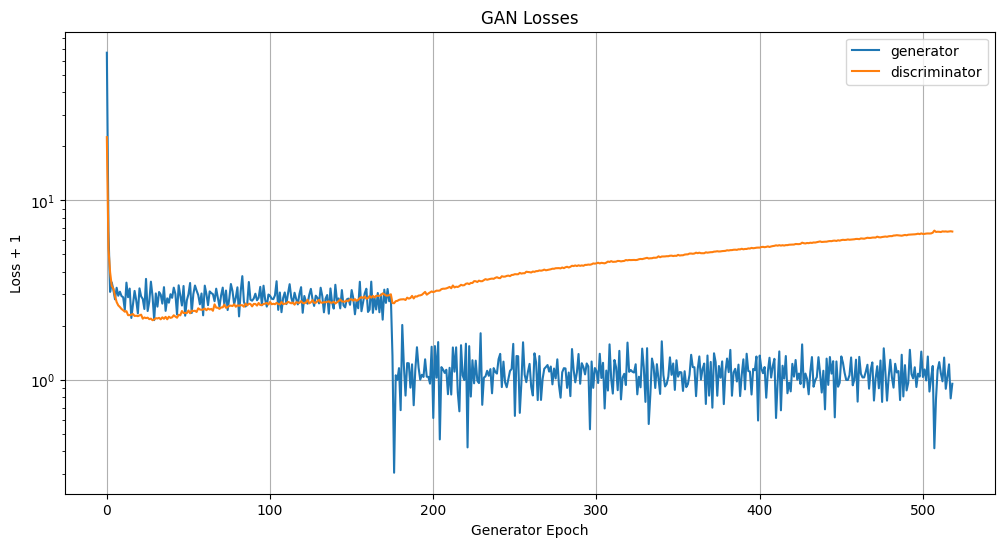

In [174]:
plot_loss([saved_gen_loss,saved_disc_loss])

Analyzing the duality gap we can see that after initially converging towards 0 it started to oscillate. This could mean that convergence wasn't achieved already.

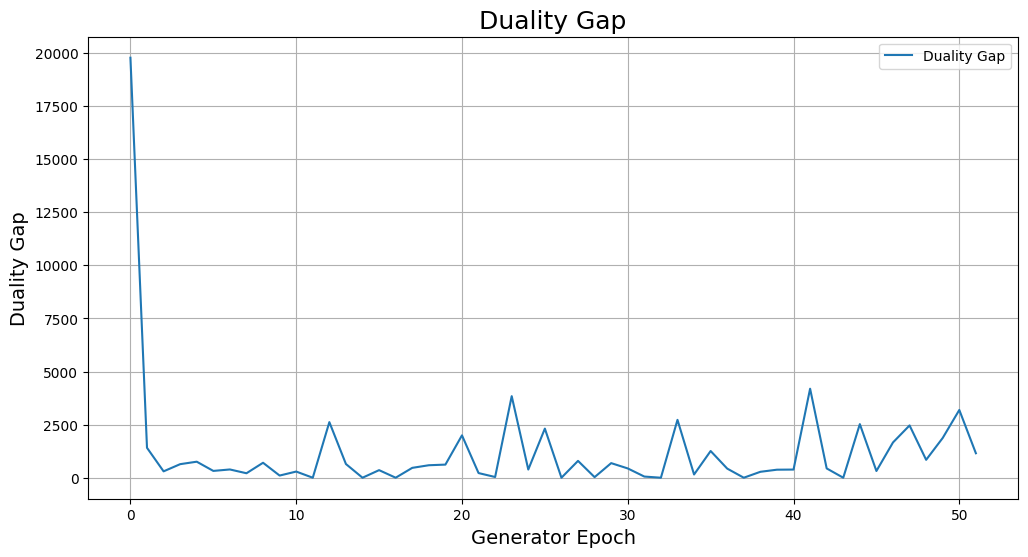

In [175]:
plot_dg(saved_dg)

Here I show examples of generated and real data:

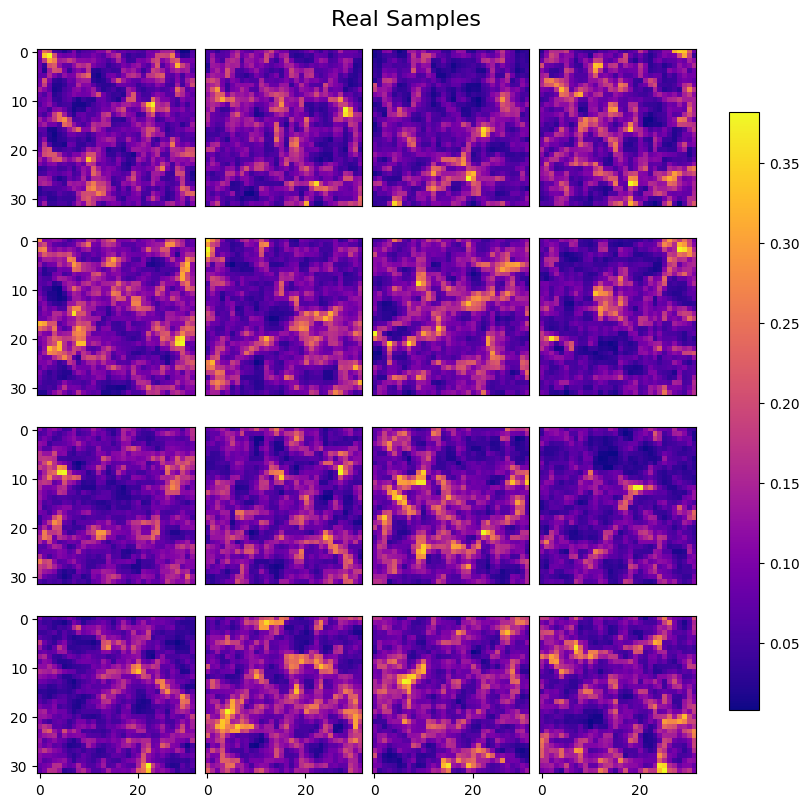

In [107]:
plot_examples_real(data_loader_test)

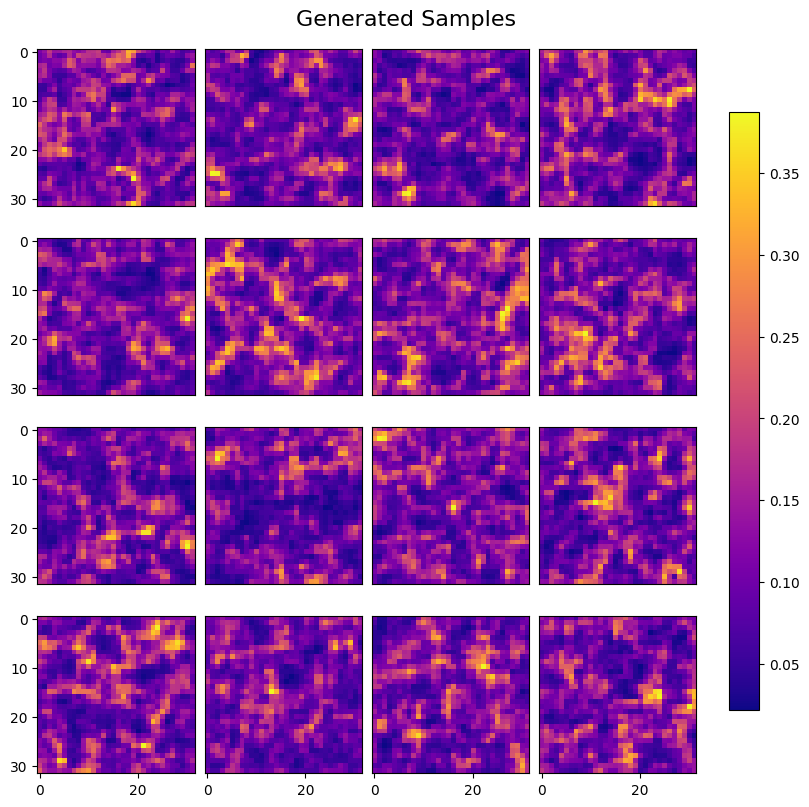

In [162]:
plot_examples_generated(generator)

The similarity is remarkable. We can also see this in the summaries:

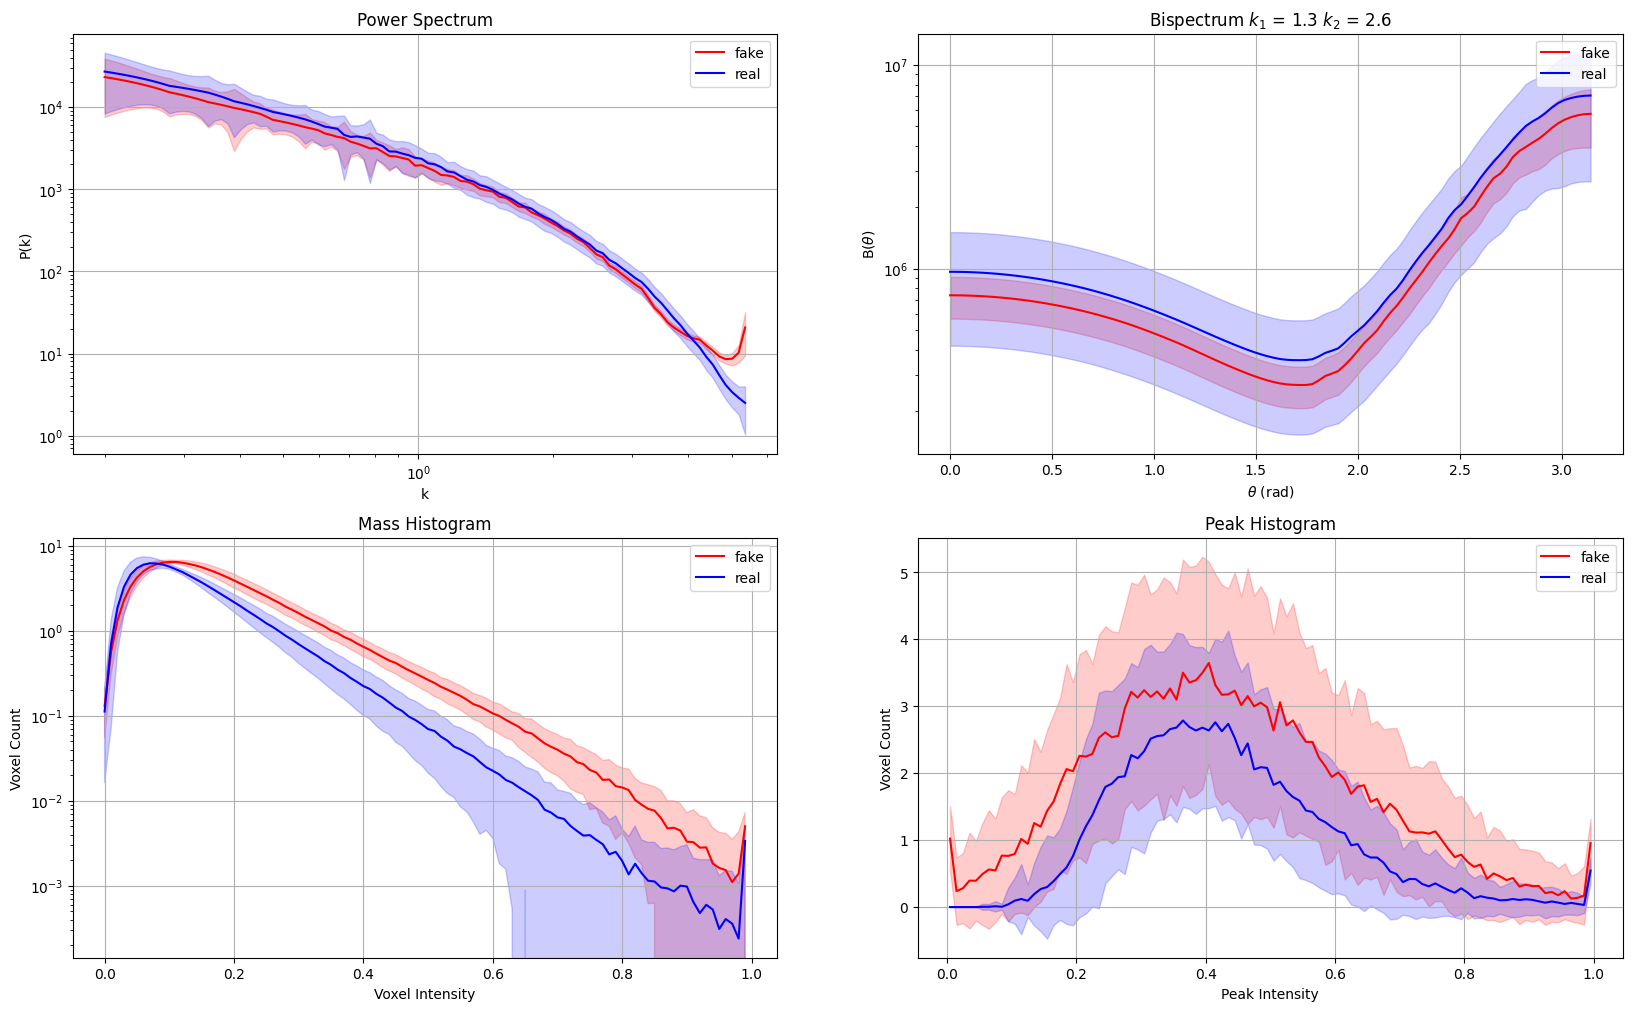

In [22]:
c = plot_final_summary(data_loader_test, generator,1.3,2.6)

As discussed in the paper we can see the power spectrum and bispectrum being very accurate at almost all scales, which means the structures are captured very well. However, the mass histogram and peak histogram reveal a slight overdensity as the generated samples appear slighly brighter. We can also see this in the low scales power spectrum (high k) as this could mean that it cannot capture properly the structure at the smallest scale. We can say we are overall satisfied with the results as we can see in the compatibility plot. For most of the bins the compatibiliy is really good except for the mass histogram were we can see a discrete compatibiliy.

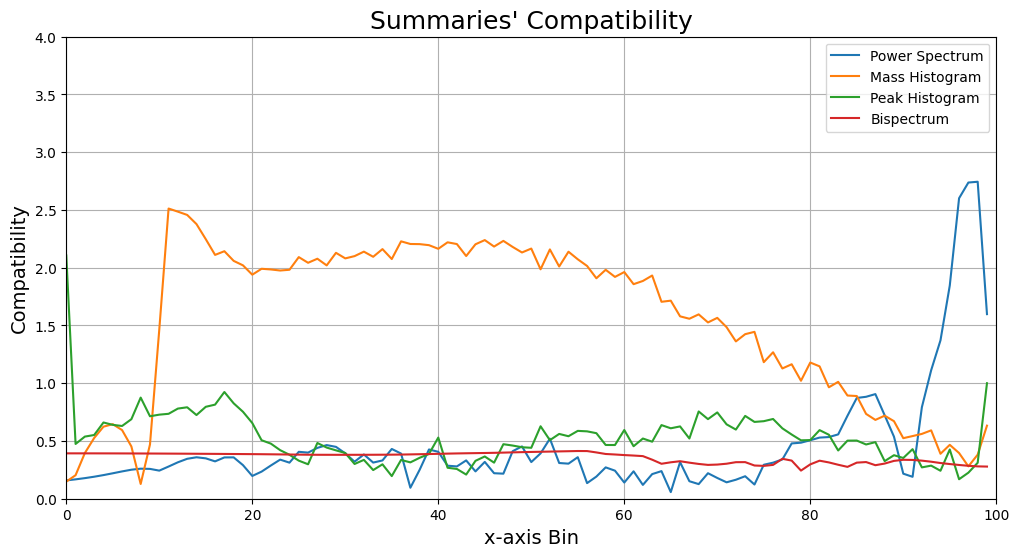

In [36]:
comp_plot(c)